In [1]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import normalize
from sklearn.model_selection import GridSearchCV



import seaborn as sns
%matplotlib inline
# %load_ext autotime

# Prep the data

In [64]:
playoff_teams = [
    "Netherlands",
    "United States",
    "Argentina",
    "Australia",
    "Japan",
    "Croatia",
    "South Korea",
    "Brazil",
    "France",
    "Poland",
    "England",
    "Senegal",
    "Morocco",
    "Spain",
    "Portugal",
    "Switzerland"
    ]

playoff_matches = [
    ("Netherlands", "United States"),
    ("Argentina", "Australia"),
    ("Japan", "Croatia"),
    ("South Korea", "Brazil"),
    ("France", "Poland"),
    ("England", "Senegal"),
    ("Morocco", "Spain"),
    ("Portugal", "Switzerland")
    ]

In [3]:
# # data from https://www.kaggle.com/code/sivahemang/fifa-world-2022-analysis-and-prediction
# df = pd.read_csv('./archive/results.csv')
df = pd.read_csv('./results.csv')

In [4]:
df["date"] = pd.to_datetime(df["date"])

# selec 2022 matches
df = df[df["date"] > "2022-01-01"]
# sort by date
df = df.sort_values(by=["date"],ascending=False)
df.shape

(888, 9)

In [5]:
# df.to_csv('./results.csv', index=False)

In [6]:
df = df.dropna()
df = df.reset_index(drop=True)
df.shape

(888, 9)

In [7]:
# get all teams
home_teams = df['home_team'].to_list()
away_teams = df['away_team'].to_list()

all_teams = set(home_teams +away_teams)
all_teams = list(all_teams)
assert len(all_teams) == 214

In [8]:
df['home_team_index'] = df['home_team'].apply(lambda x: all_teams.index(x))
df['away_team_index'] = df['away_team'].apply(lambda x: all_teams.index(x))

In [9]:
df["home_team_indicator"] = np.where(df["home_score"]>df["away_score"],1,0)
df["away_team_indicator"] = np.where(df["home_score"]<df["away_score"],1,0)

df = df.fillna(0)

In [10]:
df["total_score"] = df["home_score"] + df["away_score"]

In [11]:
# home_team_index = df["home_team_index"].to_list()
# home_team_index = df["away_team_index"].to_list()

# home_score = df["home_score"].values
# away_score = df["away_score"].values

# home_team_indicator = np.where(a_score>b_score,1,0)
# away_team_indicator = np.where(a_score<b_score,1,0)

In [12]:
# df = df[["home_team_index", "home_score", "away_team_index", "away_score", "home_team_indicator", "away_team_indicator"]]
# df.head()

In [13]:
df_test = df.loc[:9,:]
df_train = df.loc[9:,:]

df_train.shape, df_test.shape

((879, 14), (10, 14))

# markov chain

In [ ]:
M = np.zeros((len(all_teams), len(all_teams)))
M.shape

In [ ]:
M[tuple(a_index), tuple(a_index)] = M[tuple(a_index), tuple(a_index)] + a_indicator + a_score/(a_score+b_score)
M[tuple(b_index), tuple(b_index)] = M[tuple(b_index), tuple(b_index)] + b_indicator + b_score/(a_score+b_score)
M[tuple(a_index), tuple(b_index)] = M[tuple(a_index), tuple(b_index)] + b_indicator + b_score/(a_score+b_score)
M[tuple(b_index), tuple(a_index)] = M[tuple(b_index), tuple(a_index)] + a_indicator + a_score/(a_score+b_score)

In [ ]:
M[np.isnan(M)] = 0
M

In [ ]:
M_normalize = normalize(M, norm='l1', axis=1)

In [ ]:
# function to calculate state at t
def update_w(w_0, t):
    w_arr = []
    w = w_0
    for i in range(t):
        w = np.dot(w, M_normalize)
    w_arr = pd.DataFrame(w.T, index= None, columns = ['score'])
    w_arr['team'] = all_teams
    return w_arr


In [ ]:
np.random.seed(42)
w_0 = np.random.uniform(low=0.0, high=1.0, size=(1,len(all_teams)))
w_0 = normalize(w_0, norm='l1')

w_10 = update_w(w_0, 10)
w_10.columns.name = 't=10'

w_100 = update_w(w_0, 100)
w_100.columns.name = 't=100'

w_1000 = update_w(w_0, 1000)
w_1000.columns.name = 't=1000'

w_10000 = update_w(w_0, 100000)
w_10000.columns.name = 't=10000'

In [ ]:
w_10000_playoff = w_10[w_10['team'].isin(playoff_teams)]

In [ ]:
w_10000_playoff.sort_values(by='score', ascending=False)

# NMF

In [15]:
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score

In [18]:
len(all_teams)

214

In [73]:
def create_input_matrix(df_input, dim=len(all_teams)):
    
    m = np.zeros((dim, dim))

    m[tuple(df_input["home_team_index"]), tuple(df_input["home_team_index"])] = m[tuple(df_input["home_team_index"]), tuple(df_input["home_team_index"])] + df_input["home_team_indicator"] + df_input["home_score"]/(df_input["total_score"])
    m[tuple(df_input["away_team_index"]), tuple(df_input["away_team_index"])] = m[tuple(df_input["away_team_index"]), tuple(df_input["away_team_index"])] + df_input["away_team_indicator"] + df_input["away_score"]/(df_input["total_score"])
    m[tuple(df_input["home_team_index"]), tuple(df_input["away_team_index"])] = m[tuple(df_input["home_team_index"]), tuple(df_input["away_team_index"])] + df_input["away_team_indicator"] + df_input["away_score"]/(df_input["total_score"])
    m[tuple(df_input["away_team_index"]), tuple(df_input["home_team_index"])] = m[tuple(df_input["away_team_index"]), tuple(df_input["home_team_index"])] + df_input["home_team_indicator"] + df_input["home_score"]/(df_input["total_score"])

    m[np.isnan(m)] = 0

    return m
    

def matrix_factorization(matrix, n_components):
    
    model = NMF(n_components=n_components,
    #  init='nndsvda',
      random_state=0)

    W = model.fit_transform(matrix)
    H = model.components_

    matrix = np.dot(W, H)


    return matrix.T


def matrix2df(matrix_pred, test, column_mapper=all_teams):

    # create NxN dataframe
    df_pred = pd.DataFrame(matrix_pred, columns=column_mapper, index=column_mapper)
    # keep rows related to the test teams
    test_teams = test["home_team"].to_list() + test["away_team"].to_list()
    df_pred = df_pred[test_teams].loc[test_teams]
    df_pred = df_pred.unstack().reset_index()

    df_pred.columns = ["home_team", "away_team", "pred_score_normalized"]

    df_pred_1 = df_pred.loc[list(map(lambda x: x in zip(test["home_team"], test["away_team"]), zip(df_pred['home_team'], df_pred['away_team']))),:].reset_index(drop=True)
    df_pred_2 = df_pred.loc[list(map(lambda x: x in zip(test["away_team"], test["home_team"]), zip(df_pred['home_team'], df_pred['away_team']))),"pred_score_normalized"].reset_index(drop=True)

    df_pred = pd.concat([df_pred_1, df_pred_2], axis=1)
    df_pred.columns = ["home_team", "away_team", "home_pred_score_normalized", "away_pred_score_normalized"]

    df_pred["pred_home_team_indicator"] = np.where(df_pred["home_pred_score_normalized"]>df_pred["away_pred_score_normalized"],1,0)
    df_pred["pred_away_team_indicator"] = np.where(df_pred["home_pred_score_normalized"]<df_pred["away_pred_score_normalized"],1,0)

    return df_pred



In [74]:
m_train = create_input_matrix(df_train)
assert m_train.shape == (214, 214)

/Users/amir/opt/anaconda3/envs/snorkel/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/amir/opt/anaconda3/envs/snorkel/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/amir/opt/anaconda3/envs/snorkel/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


2


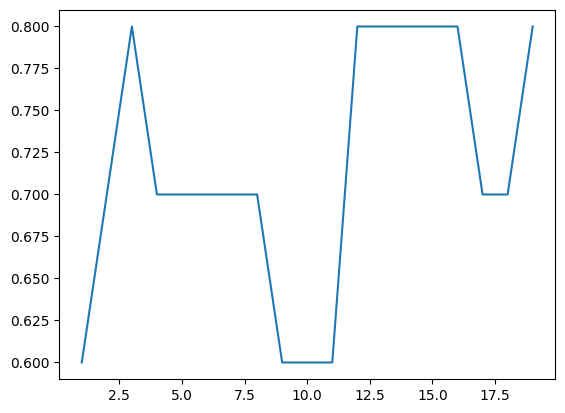

In [75]:
acc_result = []
for n in range(1,  20):
    new_m = matrix_factorization(m_train, n)
    df_pred = matrix2df(new_m, df_test)
    acc_result.append(accuracy_score(df_test["home_team_indicator"], df_pred["pred_home_team_indicator"]))

sns.lineplot(x=range(1,20), y=acc_result)
best_n = acc_result.index(max(acc_result))
print(best_n)

In [76]:
m_full = create_input_matrix(df)
assert m_full.shape == (214, 214)


m_full = matrix_factorization(m_full, best_n)


In [80]:
df_playoffs = pd.DataFrame(playoff_matches, columns=['home_team', "away_team"])

matrix2df(m_full, df_playoffs).to_csv('./predition_3122022.csv')

In [ ]:
for idx, row in df_test.iterrows():
    game = (row["home_team"], row["away_team"])
    if row["home_team_index"] > 0:
        winner = game[0]
    elif row["away_team_index"] > 0:
        winner = game[1]

    print(f'real data for {game[0]} vs {game[1]}: {row["home_score"]} - {row["away_score"]} for {winner}')

    # predicted
    pred_home_score = df_result[game[0]].loc[game[1]]
    pred_away_score = df_result[game[1]].loc[game[0]]
    print(pred_home_score, pred_away_score)

    if pred_home_score > pred_away_score:
        pred_winner = game[0]
        score = pred_home_score
    elif pred_home_score < pred_away_score:
        pred_winner = game[1]
        score = pred_away_score
    else:
        pred_winner = "draw"
        score = "draw"

    print(f"predicted: {winner}, {score} \n\n")

    print()
    







In [ ]:
    """
    ax + by = c
    dx +ey =f 
    """

a = -0.85
b = 0.15
c = 0
d =0.1
e = 1.1
f = 0
A = np.array([[a, b], [d, e]])
B = np.array([[c], [f]])
print(np.linalg.inv(A) @ B)

In [ ]:
for m, (home, away) in enumerate(matches):
    home_score = df_result[home].loc[away]
    away_score = df_result[away].loc[home]
    # print(home_score, away_score)
    if home_score > away_score:
        winner = home
        score = home_score
    elif home_score < away_score:
        winner = away
        score = away_score
    else:
        winner = "draw"
        score = "draw"

    print(f"Match: {home} vs {away}------ result: {winner}, {score}")

    






In [ ]:
print(df_result["Argentina"].loc["Australia"])
print(df_result["Argentina"].loc["Australia"])


In [ ]:
df_result["Netherlands"].loc["United States"]